Brennan Duff


Assignment 4


Training a GAN on the LSUN Bedrooms Dataset

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
import zipfile
import os
import random
import shutil
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    metrics,
    optimizers,
)

# Hyperparameters for the model and training
IMAGE_SIZE = 64      # Dimension of input images (64x64 pixels)
CHANNELS = 3         # Number of channels (1 for grayscale, 3 for RGB)
BATCH_SIZE = 512     # Batch size for training
Z_DIM = 100          # Dimensionality of the latent (noise) space

EPOCHS = 50          # Number of training epochs
ADAM_BETA_1 = 0.5    # Adam optimizer beta_1 parameter for discriminator stability
ADAM_BETA_2 = 0.999  # Adam optimizer beta_2 parameter
LEARNING_RATE = 0.0002  # Learning rate for both generator and discriminator
NOISE_PARAM = 0.1       # Noise level for label smoothing

In [ ]:

# Mount Google Drive to access dataset stored there

drive.mount('/content/drive')

# Extract dataset from Google Drive
zip_file_path = '/content/drive/My Drive/TrainingSet/archive.zip'
extract_to = '/content'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)
# List the contents of the 'content' directory
os.listdir('/content')

Mounted at /content/drive


['.config', 'sample', 'drive', 'data0', 'sample_data']

In [ ]:
# Set the path to the original dataset and define the subset size
original_dataset_dir = '/content/data0/lsun/bedroom/'
subset_dir = '/content/data0/lsun/bedroom/subset'
os.makedirs(subset_dir, exist_ok=True)  # Create the subset directory if it doesn't exist

# Define the number of images you want in the subset (e.g., 1000)
subset_size = 15000

all_images = []
# Walk through all subfolders of original_dataset_dir, excluding the subset directory
for root, _, files in os.walk(original_dataset_dir):
    # Skip the subset directory to avoid copying files to themselves
    if root.startswith(subset_dir):
        continue
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):  # Add more extensions if needed
            all_images.append(os.path.join(root, file))

# Select a random subset
subset_images = random.sample(all_images, min(subset_size, len(all_images)))


# Copy the selected images to the subset directory
for img_path in subset_images:
    dst_path = os.path.join(subset_dir, os.path.basename(img_path))
    shutil.copy(img_path, dst_path)

print(f"Subset of {len(subset_images)} images created at {subset_dir}")

Subset of 15000 images created at /content/data0/lsun/bedroom/subset


In [ ]:

# Load and preprocess the training dataset
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data0/lsun/bedroom/subset",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)


Found 15000 files belonging to 1 classes.


In [ ]:

# Preprocessing function: normalize pixel values to [-1, 1]
def preprocess(img):
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img

# Apply preprocessing to the training dataset
train = train_data.map(lambda x: preprocess(x))

# Display a sample batch of preprocessed training images (custom function assumed to be defined in utils.py)
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks') # Replace with your actual path
from utils import display, sample_batch
train_sample = sample_batch(train)




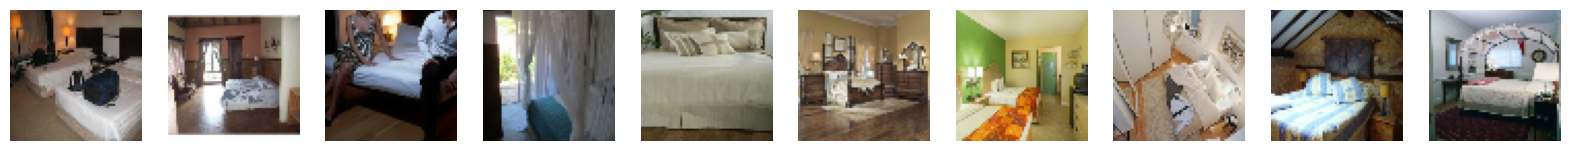

In [ ]:
display(train_sample)

In [ ]:


# Define the Discriminator model architecture
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid", use_bias=False, activation="sigmoid")(x)
discriminator_output = layers.Flatten()(x)

# Compile Discriminator model
discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

# Define the Generator model architecture
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(CHANNELS, kernel_size=4, strides=2, padding="same", use_bias=False, activation="tanh")(x)

# Compile Generator model
generator = models.Model(generator_input, generator_output)
generator.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                             

In [ ]:
# Define the DCGAN class to handle the training of both models
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    # Compile function to set optimizers and loss functions
    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        # Metrics for tracking progress
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.d_real_acc_metric, self.d_fake_acc_metric, self.d_acc_metric, self.g_loss_metric, self.g_acc_metric]

    # Training step function for a single batch
    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Generate fake images and calculate discriminator and generator losses
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(generated_images, training=True)

            # Label smoothing for more stable training
            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(tf.shape(real_predictions))
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(tf.shape(fake_predictions))

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0
            g_loss = self.loss_fn(real_labels, fake_predictions)

        # Calculate gradients and update the weights of the models
        gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        gradients_of_generator = gen_tape.gradient(g_loss, self.generator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state([real_labels, fake_labels], [real_predictions, fake_predictions])
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

# Instantiate and compile the DCGAN model
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=Z_DIM)

In [ ]:

dcgan.compile(
    d_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
    g_optimizer=optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2),
)

In [ ]:


# Callback to generate and display sample images at the end of each epoch
class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        # Generate images from random noise for evaluation
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(generated_images)


In [ ]:


# Train the DCGAN model on the preprocessed training dataset
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[ImageGenerator(num_img=10, latent_dim=Z_DIM)],
)


In [ ]:
# Sample some points in the latent space, from the standard normal distribution

grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 0s 204ms/step


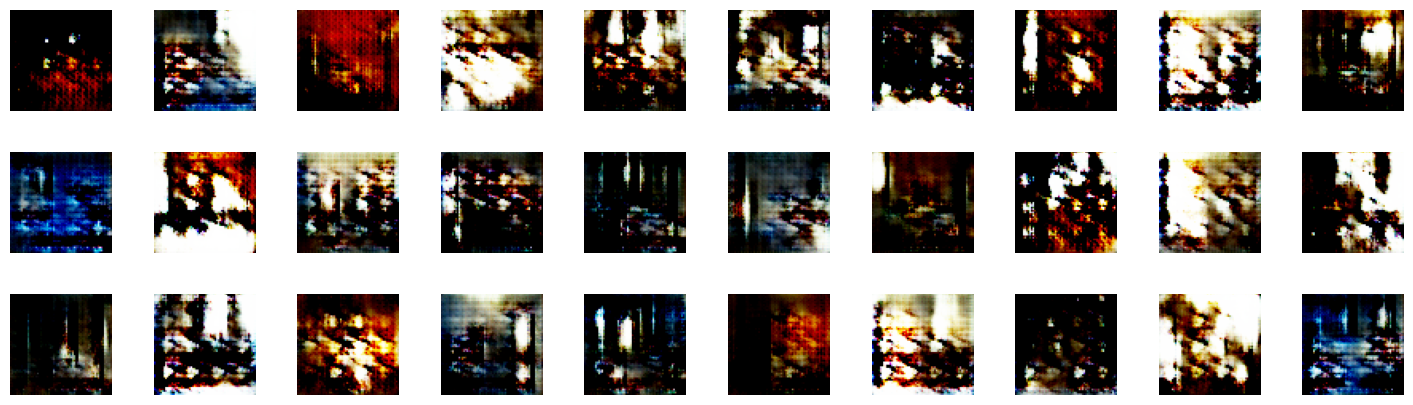

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [ ]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [ ]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

1/1 [==============================] - 0s 42ms/step


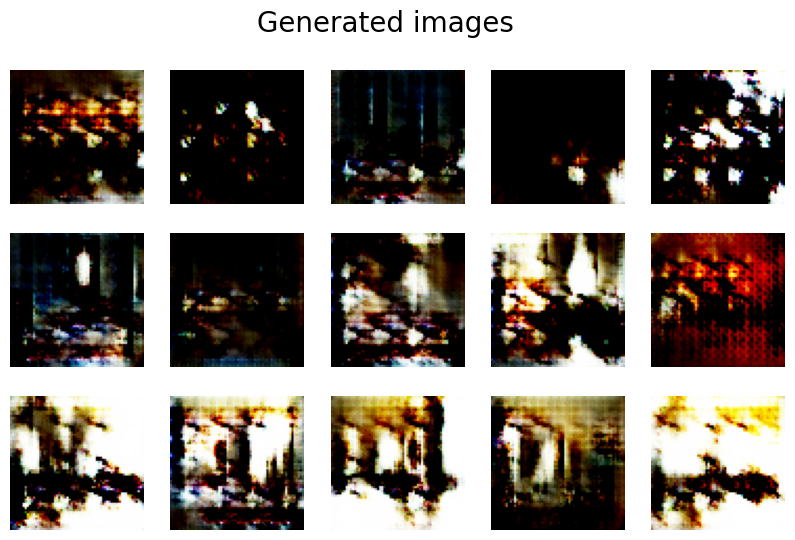

In [ ]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

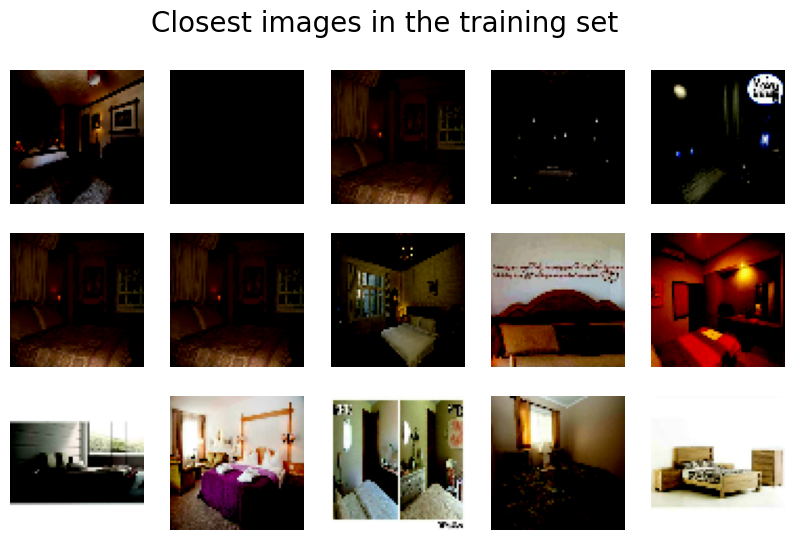

In [ ]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

Discuss the trade-off between generating high-quality images and maintaining diversity in the output. Are the generated images too similar, or does the model capture a wide range of bedroom styles?


*   I imagine the trade off would be that if the model focused to much on quality, it would only produce a relatively similar set of images due to sacrificing diversity. Conversely, increasing diveristy increase the artifacting and lowers quality.


Consider on potential enhancements to the model architecture or training process. Would experimenting with different hyperparameters or batch sizes yield better results?


*   I imagine training on a full dataset might actually create a coherent image. infact, the few epochs I could get done on tpu at full dataset were very progressing well, as far as I could tell before being cut off from the TPU.


What are the practical applications for this type of generative model?


*   I believe this model would be very practical when you have access to an abundace of resources and training material. Being hamstrung by colab's cutoff for TPU useage has made it impossible to actually tweak the model and generate a good looking image after countless reruns. Therefore, practical applications include an environment where there are abudant resources to power the model. As for the actual applications themselves, generating new designs for fashion or other products could be used to help inspire those in the design process.